# First paper - Look-up table
### Climatology of wind and solar power with synoptic weather patterns
<br>(2021-11-01) use **statistics** and **regions**
- Table: weather types associated with high (low) production 1-, 5-, 10-day events for PV, wind, and total production

<br> **Note**: Regions selected still by rectangles
<br> This notebook resamples xarray of energy output to daily first (keep lon-lat), before calculating daily time series.
The notebook Paper1_Fig3-4 preprocess calculates hourly time series first before resampling to daily time series.
--> the range of difference between two methods is +/- 3e-12, negligible

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
# import seaborn as sns

import matplotlib.pyplot as plt
from pylab import savefig
plt.switch_backend('agg')  # save image in plt

from utils_LH import Dir, new_lat, new_lon, df_GWL, list_lgcGWL, anomalies_perGWL, df_GWL_season, GWL_groups

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]  # increase size of inline figure

/net/respos/linhho/energy_model/
/home/linhho/Documents/Code_PhD/CONST//COSMO_REA6_CONST_withOUTsponge.nc
   Year  Month  Day  id_EGWL EGWL  id_lgcGWL lgcGWL       Date  Season
0  1995      1    1       20   Np         13     Nz 1995-01-01  winter
1  1995      1    2       20   Np         13     Nz 1995-01-02  winter
2  1995      1    3       20   Np         13     Nz 1995-01-03  winter
3  1995      1    4        7  BMp         10     BM 1995-01-04  winter
4  1995      1    5        7  BMp         10     BM 1995-01-05  winter
      Year  Month  Day  id_EGWL EGWL  id_lgcGWL lgcGWL       Date  Season
9232  2020      4   11        1  HMa          9     HM 2020-04-11  winter
9233  2020      4   12        1  HMa          9     HM 2020-04-12  winter
9234  2020      4   13       18  HBc         16     HB 2020-04-13  winter
9235  2020      4   14       18  HBc         16     HB 2020-04-14  winter
9236  2020      4   15       18  HBc         16     HB 2020-04-15  winter


/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [2]:
# select only period of interest <==========
period = [1995,2017]
name_PERIOD = '{}_{}'.format(period[0], period[1])
name_PERIOD

'1995_2017'

In [3]:
# Read hourly GWL data, find list of indices for each GWL
df_daily = df_GWL_season.loc[(df_GWL['Year']>=period[0]) & (df_GWL['Year']<=period[1])].copy()  # deep copy to create a real new copy not depend on the old df
df_hourly =  df_daily.set_index('Date').to_period().resample('H').ffill()
df_hourly.reset_index(drop=False, inplace=True)
print(df_hourly[-5:])

                    Date  Year  Month  Day  id_EGWL EGWL  id_lgcGWL lgcGWL  \
201619  2017-12-31 19:00  2017     12   31       10   Wz          2     Wz   
201620  2017-12-31 20:00  2017     12   31       10   Wz          2     Wz   
201621  2017-12-31 21:00  2017     12   31       10   Wz          2     Wz   
201622  2017-12-31 22:00  2017     12   31       10   Wz          2     Wz   
201623  2017-12-31 23:00  2017     12   31       10   Wz          2     Wz   

        Season  
201619  winter  
201620  winter  
201621  winter  
201622  winter  
201623  winter  


In [6]:
# read energy data
fname = Dir['out_dir'] + '????_PV_wind_generation_v2.nc'
ds = xr.open_mfdataset(fname, parallel=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 106, lon: 103, time: 201624)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 ... 2017-12-31T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    PV2050_CF  (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp2050     (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp_CF      (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp2050_CF  (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    Wp         (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
    PV2050     (time, lon, lat) float64 dask.array<chunksize=(8760, 103, 106), meta=np.ndarray>
Attributes:
    Conventions:  
    Title:        Energy model output version 2 (2021-09-07)
    Author:       Linh Ho, Institute of Geophysics and Meteorology, Universit...
    History:      2021-11-18 16:51:07.479371 Python2
    References:   
    Notes:        Wind speed at hubheight interpolated from wind at level 36 ...

In [7]:
#  This notebook resamples xarray of energy output to daily first (keep lon-lat), before calculating daily time series.
# The notebook Paper1_Fig3-4 preprocess calculates hourly time series first before resampling to daily time series.
# --> the range of difference between two methods is +/- 3e-12, negligible
ds_daily = ds.resample(time="1D").sum()
ds_daily

<xarray.Dataset>
Dimensions:    (lat: 106, lon: 103, time: 8401)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2017-12-31
Dimensions without coordinates: lat, lon
Data variables:
    PV2050_CF  (time, lon, lat) float64 dask.array<chunksize=(1, 103, 106), meta=np.ndarray>
    Wp2050     (time, lon, lat) float64 dask.array<chunksize=(1, 103, 106), meta=np.ndarray>
    Wp_CF      (time, lon, lat) float64 dask.array<chunksize=(1, 103, 106), meta=np.ndarray>
    Wp2050_CF  (time, lon, lat) float64 dask.array<chunksize=(1, 103, 106), meta=np.ndarray>
    Wp         (time, lon, lat) float64 dask.array<chunksize=(1, 103, 106), meta=np.ndarray>
    PV2050     (time, lon, lat) float64 dask.array<chunksize=(1, 103, 106), meta=np.ndarray>

### Find events that last 5 (10) days or longer

In [8]:
# RIDGE plot of density of duration for each GWL
# Duration of each GWL: hit or miss 1 or 0 time series of yes/no one particular GWL -> count consecutive non-NaN each GWL in numpy
a = [False, True, True, True, False, False, True, True, False, True, True]  # test

# Count consecutive Trues as duration of that GWL and store in a list
# https://stackoverflow.com/questions/44611125/pandas-count-the-first-consecutive-true-values

from numba import njit
@njit
def first_true(a):
    """
    Input: list of boolean
    Output: (duration, first_day, end_day)
            arrays of consecutive True
    
    """
    
    duration = []
    first_day = []
    c = 0
    true_started = False
    for i, j in enumerate(a):
        if j : 
            c += 1
            # only take the day1 (start of True series) if before that is False
            if not true_started:      true_started = True;    first_day.append(i)
            if (i == len(a)-1):       duration.append(c)  # make sure to count the last bit
        else:
            duration.append(c)
            c = 0
            true_started = False
    duration = [i for i in duration if i != 0]
#     end_day as index of python, i.e. the actual end day is in (n-1) position
    return np.array(duration), np.array(first_day), np.array(first_day) + np.array(duration)

first_true(a)

/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function 'first_true'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-8-d333890dc648>", line 10:
@njit
def first_true(a):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


(array([3, 2, 2]), array([1, 6, 9]), array([ 4,  8, 11]))

In [9]:
# convert series of lgcGWL to True when match the GWL and False otherwise
GWL_series = np.array(df_daily.reset_index()['lgcGWL'])

GWL_duration = pd.DataFrame()
for GWL in list_lgcGWL:
    a = np.where(GWL_series==GWL, True, False)
    tmp = pd.DataFrame({'GWL': GWL, 
                        'Duration':first_true(a)[0], 
                        'start_day_index': first_true(a)[1],
                        'start_day': (df_daily.reset_index()['Date'][first_true(a)[1]]),
                        'end_day_index': first_true(a)[2],
                        'end_day': list(df_daily.reset_index()['Date'][first_true(a)[2]-1])  # the exact last day of same GWL
                        })
    GWL_duration = GWL_duration.append(tmp)
GWL_duration['end_day_index'] = GWL_duration['start_day_index'] + GWL_duration['Duration'] -1

GWL_duration

,GWL,Duration,start_day_index,start_day,end_day_index,end_day
0,Nz,3,0,1995-01-01,2,1995-01-03
10,Nz,3,10,1995-01-11,12,1995-01-13
85,Nz,4,85,1995-03-27,88,1995-03-30
97,Nz,2,97,1995-04-08,98,1995-04-09
239,Nz,3,239,1995-08-28,241,1995-08-30
...,...,...,...,...,...,...
7746,HB,6,7746,2016-03-17,7751,2016-03-22
7895,HB,3,7895,2016-08-13,7897,2016-08-15
7998,HB,4,7998,2016-11-24,8001,2016-11-27
8118,HB,3,8118,2017-03-24,8120,2017-03-26


In [123]:
# Average length of events for each GWL
GWL_duration.groupby('GWL')['Duration'].mean()
# (ts_toplot[ts_toplot['Season']=='winter'].groupby(['Group']).mean() 

GWL
BM      3.412281
HB      3.855072
HFa     3.467742
HFz     3.541667
HM      3.280374
HNFa    3.804348
HNFz    3.758621
HNa     3.466667
HNz     3.283333
NEa     3.102041
NEz     3.619048
NWa     3.426667
NWz     3.620690
Na      3.244444
Nz      2.979167
SEa     3.505882
SEz     3.500000
SWa     3.350427
SWz     3.669492
Sa      3.397727
Sz      3.174603
TB      3.846154
TM      3.238095
TrM     3.371212
TrW     3.058824
Wa      3.564706
Ws      3.285714
Ww      3.148148
Wz      3.895522
Name: Duration, dtype: float64

In [125]:
GWL_duration[GWL_duration['Duration']>=7]  # 8401 events 1-day, 443 events >=5, 19 events >=10 days

,GWL,Duration,start_day_index,start_day,end_day_index,end_day
572,BM,9,572,1996-07-26,580,1996-08-03
642,BM,7,642,1996-10-04,648,1996-10-10
1320,BM,8,1320,1998-08-13,1327,1998-08-20
1421,BM,12,1421,1998-11-22,1432,1998-12-03
1699,BM,7,1699,1999-08-27,1705,1999-09-02
...,...,...,...,...,...,...
7606,Sa,7,7606,2015-10-29,7612,2015-11-04
1118,HB,8,1118,1998-01-23,1125,1998-01-30
4045,HB,7,4045,2006-01-28,4051,2006-02-03
4369,HB,7,4369,2006-12-18,4375,2006-12-24


## Trend in 1,5,10-day events over the year
Reviewer 2 (2023-09-07)

In [13]:
GWL_duration['start_day'] = pd.to_datetime(GWL_duration['start_day'])
GWL_duration['Year'] = GWL_duration['start_day'].dt.year
GWL_duration

,GWL,Duration,start_day_index,start_day,end_day_index,end_day,Year
0,Nz,3,0,1995-01-01,2,1995-01-03,1995
10,Nz,3,10,1995-01-11,12,1995-01-13,1995
85,Nz,4,85,1995-03-27,88,1995-03-30,1995
97,Nz,2,97,1995-04-08,98,1995-04-09,1995
239,Nz,3,239,1995-08-28,241,1995-08-30,1995
...,...,...,...,...,...,...,...
7746,HB,6,7746,2016-03-17,7751,2016-03-22,2016
7895,HB,3,7895,2016-08-13,7897,2016-08-15,2016
7998,HB,4,7998,2016-11-24,8001,2016-11-27,2016
8118,HB,3,8118,2017-03-24,8120,2017-03-26,2017


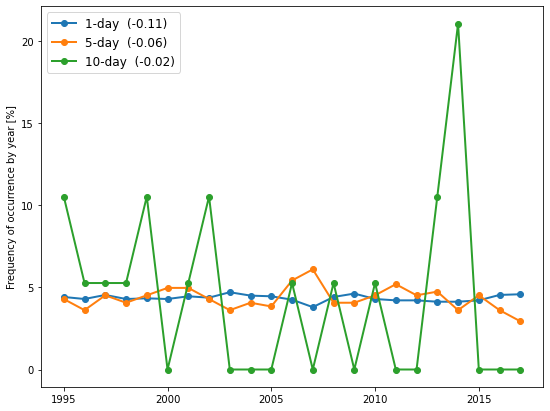

In [224]:
fig, ax = plt.subplots(figsize=(9,7))

for length in [1,5,10]:
    tmp = GWL_duration[GWL_duration['Duration'] >= length].copy().groupby('Year').size()
    tmp = tmp.reindex(range(1995,2018),fill_value=0)

#     test_regression = test[test['Group']==group]
    x = tmp.index
    y = tmp.values
    (m, b) = np.polyfit(x, y, 1)
    yp = np.polyval([m, b], x)

    ax.plot(tmp/tmp.sum()*100, 'o-', label=str(length) + '-day  ({:.2f})'.format(m), linewidth=2)
#     ax.plot(tmp/tmp.sum()*100, label=str(length) + ' day, slope {:.2f}'.format(m), linewidth=2)
#     ax.plot(x, yp, linewidth=3)
#     print('Slope of {} is {:.2f}'.format(group, m))

ax.legend(fontsize=12)
ax.set_ylabel('Frequency of occurrence by year [%]')
fig.savefig('Paper1/Paper1_SUP_{}_trend_events_1_5_10days_point.pdf'.format(name_PERIOD), dpi=300, bbox_inches = "tight")

In [213]:
GWL_duration[GWL_duration['Duration'] >= 8].copy().groupby('Year').size().sum()


69

### Define events lasting for 5 and 10 days or longer

In [57]:
# # Selection events that last 5 days or longer from GWL_duration
# # get the indices then assign is_5day_event to be True in TS_all time series
# # end-day is **included** in the .loc[range]

# TS_all = TS_all.set_index('time').copy()

# n = 5
# TS_all['is_{}day_event'.format(n)] = False
# for idx in GWL_duration.query('Duration>={}'.format(n)).index.tolist():
#     TS_all.loc[GWL_duration.loc[idx, 'start_day']:GWL_duration.loc[idx, 'end_day'], 'is_{}day_event'.format(n)] = True
    
# n = 10
# TS_all['is_{}day_event'.format(n)] = False
# for idx in GWL_duration.query('Duration>={}'.format(n)).index.tolist():
#     TS_all.loc[GWL_duration.loc[idx, 'start_day']:GWL_duration.loc[idx, 'end_day'], 'is_{}day_event'.format(n)] = True

In [83]:
df_daily

,Year,Month,Day,id_EGWL,EGWL,id_lgcGWL,lgcGWL,Date,Season
0,1995,1,1,20,Np,13,Nz,1995-01-01,winter
1,1995,1,2,20,Np,13,Nz,1995-01-02,winter
2,1995,1,3,20,Np,13,Nz,1995-01-03,winter
3,1995,1,4,7,BMp,10,BM,1995-01-04,winter
4,1995,1,5,7,BMp,10,BM,1995-01-05,winter
...,...,...,...,...,...,...,...,...,...
8396,2017,12,27,49,TrWr,29,TrW,2017-12-27,winter
8397,2017,12,28,49,TrWr,29,TrW,2017-12-28,winter
8398,2017,12,29,10,Wz,2,Wz,2017-12-29,winter
8399,2017,12,30,10,Wz,2,Wz,2017-12-30,winter


In [84]:
GWL_duration

,GWL,Duration,start_day_index,start_day,end_day_index,end_day,Year,Event_category
0,Nz,3,0,1995-01-01,2,1995-01-03,1995,1.0
10,Nz,3,10,1995-01-11,12,1995-01-13,1995,1.0
85,Nz,4,85,1995-03-27,88,1995-03-30,1995,1.0
97,Nz,2,97,1995-04-08,98,1995-04-09,1995,1.0
239,Nz,3,239,1995-08-28,241,1995-08-30,1995,1.0
...,...,...,...,...,...,...,...,...
7746,HB,6,7746,2016-03-17,7751,2016-03-22,2016,5.0
7895,HB,3,7895,2016-08-13,7897,2016-08-15,2016,1.0
7998,HB,4,7998,2016-11-24,8001,2016-11-27,2016,1.0
8118,HB,3,8118,2017-03-24,8120,2017-03-26,2017,1.0


In [86]:
# Selection events that last 5 days or longer from GWL_duration
# get the indices then assign is_5day_event to be True in df_daily_with_duration time series
# end-day is **included** in the .loc[range]

df_daily_with_duration = df_daily.set_index('Date').copy()

n = 2
df_daily_with_duration['is_{}day_event'.format(n)] = False
for idx in GWL_duration.query('Duration>={}'.format(n)).index.tolist():
    df_daily_with_duration.loc[GWL_duration.loc[idx, 'start_day']:GWL_duration.loc[idx, 'end_day'], 'is_{}day_event'.format(n)] = True

n = 4
df_daily_with_duration['is_{}day_event'.format(n)] = False
for idx in GWL_duration.query('Duration>={}'.format(n)).index.tolist():
    df_daily_with_duration.loc[GWL_duration.loc[idx, 'start_day']:GWL_duration.loc[idx, 'end_day'], 'is_{}day_event'.format(n)] = True
    
n = 8
df_daily_with_duration['is_{}day_event'.format(n)] = False
for idx in GWL_duration.query('Duration>={}'.format(n)).index.tolist():
    df_daily_with_duration.loc[GWL_duration.loc[idx, 'start_day']:GWL_duration.loc[idx, 'end_day'], 'is_{}day_event'.format(n)] = True

## Stats for each domain 
(Europe, Germany, Iberia, Scandinavina)- by rectangle

/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


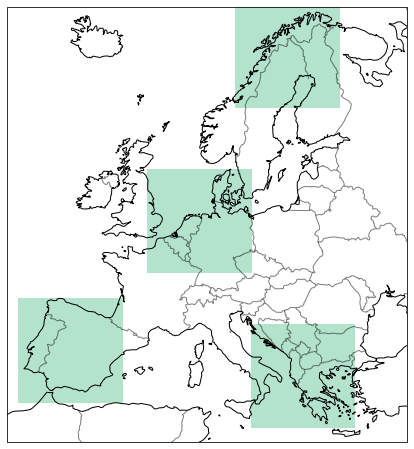

In [106]:
import cartopy
import cartopy.crs as ccrs

var = ds['Wp2050'][12,:,:].load() 
# reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 25,45,15,35
# var[25:45,15:35] = 1000
# var[50:70,40:60] = 500
# var[30:50,60:80] = 700

## Scandinavia
# reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 70,90,50,70


var[:] = np.nan
var[25:45,15:35] = 50  # Iberia
var[50:70,40:60] = 50  # Germany & North Sea
var[20:40,60:80] = 50  # Eastern Europe
### var[70:90,50:70] = 100  # Scandinavia
var[82:102,57:77] = 50  # Scandinavia  ## new, ver2, to capture the tip of Scandinavia which is anti-correlated with Western Europe (2022-05-30)

# var[reg_lon1:reg_lon2, reg_lat1:reg_lat2] = 200
my_cmap = plt.cm.get_cmap('Pastel2')

rp = ccrs.RotatedPole(pole_longitude=-162.0,
                  pole_latitude=39.25,
                  globe=ccrs.Globe(semimajor_axis=6370000,
                                   semiminor_axis=6370000))

fig = plt.figure()
ax = fig.add_subplot()
ax = plt.axes(projection=rp ) 
ax.pcolormesh(new_lon, new_lat, var,
         transform=ccrs.PlateCarree(), cmap=my_cmap)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')

ax.set_extent([-23, 11, -16, 21], crs=rp)  # left, right, bottom, top

# fig.savefig('Paper1_v4_Fig0_4regions_squares.pdf'.format(name_PERIOD), dpi=300, transparent=True)



In [51]:
# Select the desired domain
## whole Europe
PV_domain = ds_daily['PV2050'] 
Wp_domain = ds_daily['Wp2050']

# var[25:45,15:35] = 1000  # Iberia
# var[50:70,40:60] = 500  # Germany & North Sea
# var[20:40,60:80] = 700  # Eastern Europe
# var[70:90,50:70] = 700  # Scandinavia

# ## Iberia
# reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 25,45,15,35

# ## Germany and North Sea
# reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 50,70,40,60

## Scandinavia
### reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 70,90,50,70
# reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 82,102,57,77  # Scandinavia  ## new, ver2, to capture the tip of Scandinavia which is anti-correlated with Western Europe (2022-05-30)


# ## Southeastern Europe
# reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 20,40,60,80


# PV_domain = ds_daily['PV2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]
# Wp_domain = ds_daily['Wp2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]



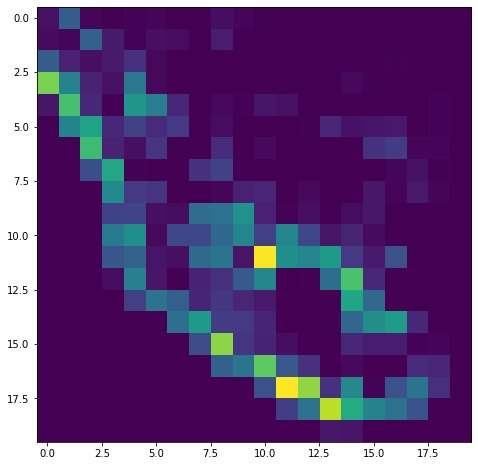

In [61]:
plt.imshow(Wp_domain[12])

In [111]:
TS_all

,time,PV,Wp,Total,GWL,Season
0,NaN,1.179390,7.185947,8.365337,Nz,winter
1,NaN,1.620167,5.129130,6.749297,Nz,winter
2,NaN,1.547156,3.514436,5.061592,Nz,winter
3,NaN,1.693324,4.232278,5.925602,BM,winter
4,NaN,1.589844,6.251648,7.841492,BM,winter
...,...,...,...,...,...,...
8396,NaN,1.065206,6.585607,7.650813,TrW,winter
8397,NaN,0.919680,4.792418,5.712098,TrW,winter
8398,NaN,1.046737,5.521419,6.568156,Wz,winter
8399,NaN,1.015782,5.817196,6.832978,Wz,winter


In [109]:
df_daily_with_duration

,Year,Month,Day,id_EGWL,EGWL,id_lgcGWL,lgcGWL,Season,is_2day_event,is_4day_event,is_8day_event
Date,,,,,,,,,,,
1995-01-01,1995,1,1,20,Np,13,Nz,winter,True,False,False
1995-01-02,1995,1,2,20,Np,13,Nz,winter,True,False,False
1995-01-03,1995,1,3,20,Np,13,Nz,winter,True,False,False
1995-01-04,1995,1,4,7,BMp,10,BM,winter,True,True,False
1995-01-05,1995,1,5,7,BMp,10,BM,winter,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,2017,12,27,49,TrWr,29,TrW,winter,True,False,False
2017-12-28,2017,12,28,49,TrWr,29,TrW,winter,True,False,False
2017-12-29,2017,12,29,10,Wz,2,Wz,winter,True,False,False


In [168]:
### NEW (2023-09-08) for reviews
### Look-up table Figure 5, looping all

df_lookup_colnames = ['Extreme', 'Energy_type', 'Duration', 'Region', 'GWL', 'Anomaly']
df_lookup2050 = pd.DataFrame(columns = df_lookup_colnames)
list_event_durations = ['is_2day_event', 'is_4day_event', 'is_8day_event']

# Select the desired domain

for region in ['Europe', 'A', 'B', 'C', 'D']:

    if region=='Europe':  ## whole Europe
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 0,103,0,106
    elif region=='A':  ## Scandinavia
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 82,102,57,77  # Scandinavia  ## new, ver2, to capture the tip of Scandinavia which is anti-correlated with Western Europe (2022-05-30)
    elif region=='B':  # ## Germany and North Sea
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 50,70,40,60
    elif region=='C':  # ## Iberia
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 25,45,15,35
    elif region=='D':  # ## Southeastern Europe
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 20,40,60,80

    PV_domain = ds_daily['PV2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]
    Wp_domain = ds_daily['Wp2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]

    # capitalised TS denotes DAILY time series
    # unit **TW/day**

    TS_all = pd.DataFrame({'Date': pd.date_range(dt.datetime(period[0],1,1,0,0,0), dt.datetime(period[1]+1,1,1,0,0,0), freq='D', closed="left"),
                               'PV': np.nansum(PV_domain, axis=(1,2))/1e6,
                               'Wp': np.nansum(Wp_domain, axis=(1,2))/1e6
                               },
                             columns = ['Date','PV', 'Wp'])
    TS_all['Total'] = TS_all['PV'] + TS_all['Wp']
    TS_all['GWL'] = df_daily['lgcGWL'].tolist()
    TS_all['Season'] = df_daily['Season'].tolist()

    print("Average **daily** the selected domain {}: PV {:.2f}, wind {:.2f}, total production {:.2f}".format(region,
                                            np.mean(TS_all['PV']), np.mean(TS_all['Wp']), np.mean(TS_all['Total'])))

    ### multiindex == dataframe of GWL and anomaly associated with high/low with different duration for energy_types, region
    ## anomaly normalised

    TS_all = TS_all.set_index("Date")
    TS_all = pd.concat([TS_all, df_daily_with_duration.iloc[:,-3:]], axis='columns')

    for energy_type in ['Total', 'PV', 'Wp']:
        for duration in list_event_durations:

            ## get rows of necessary values
            TS_all_groupby_GWL = TS_all[TS_all[duration]==True].groupby(['GWL']).mean()
            tmp_list_low  = ['Lowest', energy_type, duration, region,
                                  TS_all_groupby_GWL[energy_type].idxmin(), (TS_all_groupby_GWL[energy_type].min()-TS_all[energy_type].mean())/TS_all[energy_type].mean()*100]
            tmp_list_high = ['Highest', energy_type, duration, region,
                                 TS_all_groupby_GWL[energy_type].idxmax(), (TS_all_groupby_GWL[energy_type].max()-TS_all[energy_type].mean())/TS_all[energy_type].mean()*100]
            tmp_df_low = pd.DataFrame([tmp_list_low], columns = df_lookup_colnames)
            tmp_df_high = pd.DataFrame([tmp_list_high], columns = df_lookup_colnames)

            ## add row to the dataframe
            df_lookup2050 = df_lookup2050.append(tmp_df_low, ignore_index=True)
            df_lookup2050 = df_lookup2050.append(tmp_df_high, ignore_index=True)

df_lookup2050

Average **daily** the selected domain Europe: PV 3.11, wind 3.63, total production 6.74
Average **daily** the selected domain A: PV 0.02, wind 0.22, total production 0.24
Average **daily** the selected domain B: PV 0.48, wind 1.25, total production 1.73
Average **daily** the selected domain C: PV 0.75, wind 0.20, total production 0.95
Average **daily** the selected domain D: PV 0.19, wind 0.03, total production 0.22


,Extreme,Energy_type,Duration,Region,GWL,Anomaly
0,Lowest,Total,is_2day_event,Europe,Ws,-12.097495
1,Highest,Total,is_2day_event,Europe,Wa,13.755199
2,Lowest,Total,is_4day_event,Europe,Ws,-15.721652
3,Highest,Total,is_4day_event,Europe,Wa,15.091092
4,Lowest,Total,is_8day_event,Europe,HB,-24.026911
...,...,...,...,...,...,...
85,Highest,Wp,is_2day_event,D,Nz,71.529923
86,Lowest,Wp,is_4day_event,D,SWz,-41.032482
87,Highest,Wp,is_4day_event,D,Nz,66.690619
88,Lowest,Wp,is_8day_event,D,SEz,-50.838734


In [162]:

# ## For total production ======== 2019 ========
# # read energy data - only for total production

fname = Dir['out_dir'] + 'scale2019/????_PV_wind_generation_scale2019.nc'
ds2019 = xr.open_mfdataset(fname, parallel=True)
ds_daily2019 = ds2019.resample(time="1D").sum()

### NEW (2023-09-08) for reviews
### Look-up table Figure 5, looping all

df_lookup2019 = pd.DataFrame(columns = df_lookup_colnames)

# Select the desired domain

for region in ['Europe', 'A', 'B', 'C', 'D']:

    if region=='Europe':  ## whole Europe
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 0,103,0,106
    elif region=='A':  ## Scandinavia
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 82,102,57,77  # Scandinavia  ## new, ver2, to capture the tip of Scandinavia which is anti-correlated with Western Europe (2022-05-30)
    elif region=='B':  # ## Germany and North Sea
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 50,70,40,60
    elif region=='C':  # ## Iberia
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 25,45,15,35
    elif region=='D':  # ## Southeastern Europe
        reg_lon1, reg_lon2, reg_lat1, reg_lat2 = 20,40,60,80

    PV_domain = ds_daily2019['PV2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]
    Wp_domain = ds_daily2019['Wp2050'][:,reg_lon1:reg_lon2, reg_lat1:reg_lat2]

    # capitalised TS denotes DAILY time series
    # unit **TW/day**

    TS_all2019 = pd.DataFrame({'Date': pd.date_range(dt.datetime(period[0],1,1,0,0,0), dt.datetime(period[1]+1,1,1,0,0,0), freq='D', closed="left"),
                               'Total2019': np.nansum(PV_domain, axis=(1,2))/1e6 + np.nansum(Wp_domain, axis=(1,2))/1e6
                               },
                             columns = ['Date','Total2019'])
    TS_all2019['GWL'] = df_daily['lgcGWL'].tolist()
    TS_all2019['Season'] = df_daily['Season'].tolist()

    print("Average 2019 **daily** the selected domain {}: total production {:.2f}".format(region, np.mean(TS_all2019['Total2019'])))

    ### multiindex == dataframe of GWL and anomaly associated with high/low with different duration for energy_types, region
    ## anomaly normalised

    TS_all2019 = TS_all2019.set_index("Date")
    TS_all2019 = pd.concat([TS_all2019, df_daily_with_duration.iloc[:,-3:]], axis='columns')

    for energy_type in ['Total2019']:
        for duration in list_event_durations:

            ## get rows of necessary values
            TS_all_groupby_GWL = TS_all2019[TS_all2019[duration]==True].groupby(['GWL']).mean()
            tmp_list_low  = ['Lowest', energy_type, duration, region,
                                  TS_all_groupby_GWL[energy_type].idxmin(), (TS_all_groupby_GWL[energy_type].min()-TS_all2019[energy_type].mean())/TS_all2019[energy_type].mean()*100]
            tmp_list_high = ['Highest', energy_type, duration, region,
                                 TS_all_groupby_GWL[energy_type].idxmax(), (TS_all_groupby_GWL[energy_type].max()-TS_all2019[energy_type].mean())/TS_all2019[energy_type].mean()*100]
            tmp_df_low = pd.DataFrame([tmp_list_low], columns = df_lookup_colnames)
            tmp_df_high = pd.DataFrame([tmp_list_high], columns = df_lookup_colnames)

            ## add row to the dataframe
            df_lookup2019 = df_lookup2019.append(tmp_df_low, ignore_index=True)
            df_lookup2019 = df_lookup2019.append(tmp_df_high, ignore_index=True)

df_lookup2019

Average 2019 **daily** the selected domain Europe: total production 1.81
Average 2019 **daily** the selected domain A: total production 0.09
Average 2019 **daily** the selected domain B: total production 0.54
Average 2019 **daily** the selected domain C: total production 0.18
Average 2019 **daily** the selected domain D: total production 0.04


,Extreme,Energy_type,Duration,Region,GWL,Anomaly
0,Lowest,Total2019,is_2day_event,Europe,HNa,-19.435067
1,Highest,Total2019,is_2day_event,Europe,Wa,22.331204
2,Lowest,Total2019,is_4day_event,Europe,HNa,-20.892574
3,Highest,Total2019,is_4day_event,Europe,Wa,24.479782
4,Lowest,Total2019,is_8day_event,Europe,SEa,-22.535229
5,Highest,Total2019,is_8day_event,Europe,Wa,32.773236
6,Lowest,Total2019,is_2day_event,A,TB,-27.833565
7,Highest,Total2019,is_2day_event,A,HB,44.423266
8,Lowest,Total2019,is_4day_event,A,Ws,-31.427434
9,Highest,Total2019,is_4day_event,A,HM,54.499223


In [170]:
from pandas.api.types import CategoricalDtype

df_lookup = pd.concat([df_lookup2050, df_lookup2019])

df_lookup['Energy_type'] = pd.Categorical(df_lookup['Energy_type'], categories=['Total2019', 'Total', 'PV', 'Wp'])
df_lookup['Region'] = pd.Categorical(df_lookup['Region'], categories=['Europe', 'A', 'B', 'C', 'D'])
df_lookup['Extreme'] = pd.Categorical(df_lookup['Extreme'], categories=['Lowest', 'Highest'])

df_lookup_gwl = df_lookup[['Extreme', 'Energy_type', 'Region', 'GWL', 'Duration']].pivot(index=["Energy_type", "Region"], columns=['Extreme', 'Duration'])['GWL'].sort_index(level=0, axis=1)
df_lookup_anomaly = df_lookup[['Extreme', 'Energy_type', 'Region', 'Anomaly', 'Duration']].pivot(index=["Energy_type", "Region"], columns=['Extreme', 'Duration'])['Anomaly'].sort_index(level=0, axis=1)
df_lookup_gwl

Extreme                   Lowest                                   Highest  \
Duration           is_2day_event is_4day_event is_8day_event is_2day_event   
Energy_type Region                                                           
Total2019   Europe           HNa           HNa           SEa            Wa   
            A                 TB            Ws            Ws            HB   
            B                 HM            HM            HM           SWz   
            C                 Wa            Wa            Wa            TB   
            D                SWz           SWz           SWa            TM   
Total       Europe            Ws            Ws            HB            Wa   
            A                 TB            Ws            Ws            HB   
            B                 HM            HM            HM            Wa   
            C                 Wa            Sa            HB            TM   
            D                 Ww            Ww           HFz           HNz   
PV          Europe            Ww            Ww           HFz          HNFa   
            A                 Ww            Ww            Sa          HNFa   
            B                 Ww            Ww           HFz          HNFa   
            C                 Ws            Ww           HFz           TrM   
            D                 Ww            Ww           HFz           HNz   
Wp          Europe           HNa            Na           HNz            Ww   
            A                 TB            TM            Ws            HB   
            B                 HM            HM           HNz           SWz   
            C                 Wa            Wa            Wa            TB   
            D                SWz           SWz           SEz            Nz   

Extreme                                         
Duration           is_4day_event is_8day_event  
Energy_type Region                              
Total2019   Europe            Wa            Wa  
            A                 HM            HM  
            B                SWz            Wa  
            C                 TB            TB  
            D                HNz           HNz  
Total       Europe            Wa           NWa  
            A                 HM            HM  
            B                SWz            Wa  
            C                NEz           HNz  
            D                HNz           HNz  
PV          Europe            Na           HNz  
            A                HNz           NEz  
            B               HNFa           SEz  
            C                NEz           HNz  
            D                HNz           SEz  
Wp          Europe            Ww            Wa  
            A                 HM            HM  
            B                SWz            Wa  
            C                 TB            TB  
            D                 Nz            TB

In [171]:
df_lookup_anomaly

Extreme                   Lowest                                   Highest  \
Duration           is_2day_event is_4day_event is_8day_event is_2day_event   
Energy_type Region                                                           
Total2019   Europe    -19.435067    -20.892574    -22.535229     22.331204   
            A         -27.833565    -31.427434    -48.198007     44.423266   
            B         -35.710916    -41.169599    -41.161858     44.265997   
            C         -21.453978    -23.814817    -42.581003     32.831105   
            D         -13.828819    -21.455284    -42.640110     19.651187   
Total       Europe    -12.097495    -15.721652    -24.026911     13.755199   
            A         -25.679341    -30.253135    -41.574527     40.908059   
            B         -25.986088    -32.176901    -40.877423     31.615682   
            C         -13.803202    -19.358788    -41.926335     18.150649   
            D         -16.719267    -21.943993    -47.340973     20.674514   
PV          Europe    -30.534142    -40.111440    -58.723229     27.724137   
            A         -40.290998    -66.467960    -98.048356     71.042754   
            B         -47.073004    -57.987156    -69.443811     55.933028   
            C         -19.151971    -26.753676    -53.145607     18.845620   
            D         -24.080222    -32.301232    -57.159035     22.568863   
Wp          Europe    -29.160011    -31.680133    -41.312344     37.090425   
            A         -29.201921    -34.547710    -52.405220     46.656114   
            B         -43.396569    -48.276640    -47.041686     54.477665   
            C         -42.586169    -49.507697    -61.211315     89.804141   
            D         -38.468721    -41.032482    -50.838734     71.529923   

Extreme                                         
Duration           is_4day_event is_8day_event  
Energy_type Region                              
Total2019   Europe     24.479782     32.773236  
            A          54.499223    106.811500  
            B          49.834932     57.339315  
            C          34.171549     52.520835  
            D          22.090186     27.272687  
Total       Europe     15.091092     15.816024  
            A          48.609723     94.723963  
            B          34.540861     38.537695  
            C          20.325672     25.472015  
            D          27.139431     41.280917  
PV          Europe     31.923535     39.763612  
            A          74.622635    163.655812  
            B          58.196824     39.392978  
            C          25.603362     36.456075  
            D          31.165338     54.114082  
Wp          Europe     40.825250     53.797629  
            A          58.240213    114.489463  
            B          61.922028     72.198469  
            C          96.689637    144.882308  
            D          66.690619     83.443430

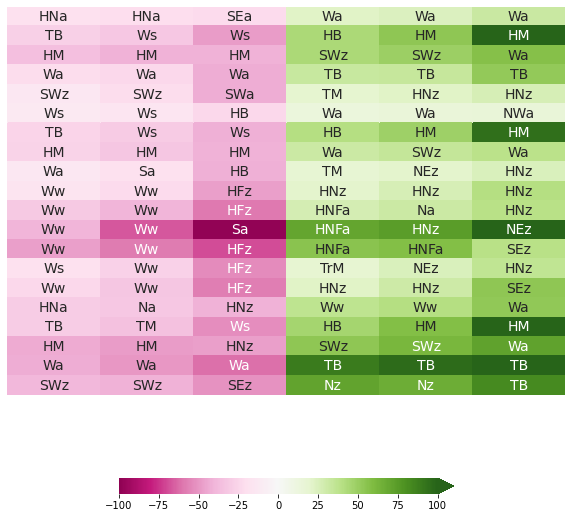

In [204]:
import seaborn as sns

plt.figure(figsize=(10,10.2))

# y_axis_labels = ['Europe', 'Iberia', 'Germany & North Sea', 'Scandinavia', 'Eastern Europe', 
#           'Europe', 'Iberia', 'Germany & North Sea', 'Scandinavia', 'Eastern Europe', 
#           'Europe', 'Iberia', 'Germany & North Sea', 'Scandinavia', 'Eastern Europe']
x_axis_labels = ['2-day', '4-day', '8-day', '2-day', '4-day', '8-day']

sns.heatmap(df_lookup_anomaly, cmap=plt.get_cmap('PiYG'), linewidths = 0.30, annot = False, vmin=-100, vmax=100, cbar_kws={"orientation": "horizontal", 'shrink': 0.6, 'extend':'max'})
myplot = sns.heatmap(df_lookup_anomaly, cmap=plt.get_cmap('PiYG'), annot=df_lookup_gwl, vmin=-100, vmax=100, annot_kws={'va':'center', "fontsize":14}, fmt="", cbar=False)
# myplot.set_xticklabels(x_axis_labels, size = 14)
# myplot.set_yticklabels(y_axis_labels, size = 14)

# use matplotlib.colorbar.Colorbar object
cbar = myplot.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)  # no tick, x label on top
plt.tick_params(labelleft=False, labelbottom=False, labeltop=False, left=False, bottom=False) ## other options are right and top
plt.xlabel("")
plt.ylabel("")

plt.savefig('Paper1/Paper1_SUP_{}_Table1_lowest_highest_production_raw_248days_noticks.pdf'.format(name_PERIOD), dpi=300, transparent=True, bbox_inches = "tight")